# Transient Universe

Model to use:

$ f(x) = \begin{cases} b & \text{if } t < 0 \\ b + A\exp{-\alpha(t-t_0)} & \text{if } t \geq t_0 \end{cases} $

Priors:

$b \in \text{Uniform} [0,50]$\
$t_0 \in \text{Uniform} [0,100]$\
$\ln(\alpha) \text{Uniform} [-5,5]$


First, read the data

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities")
from Utilities import plot_settings

In [4]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Exam\Data\transient.npy")

In [5]:
time = data.T[0]
flux = data.T[1]
ferr = data.T[2]

In [6]:
import scipy

Exploring data

Text(0.5, 1.0, 'Raw data')

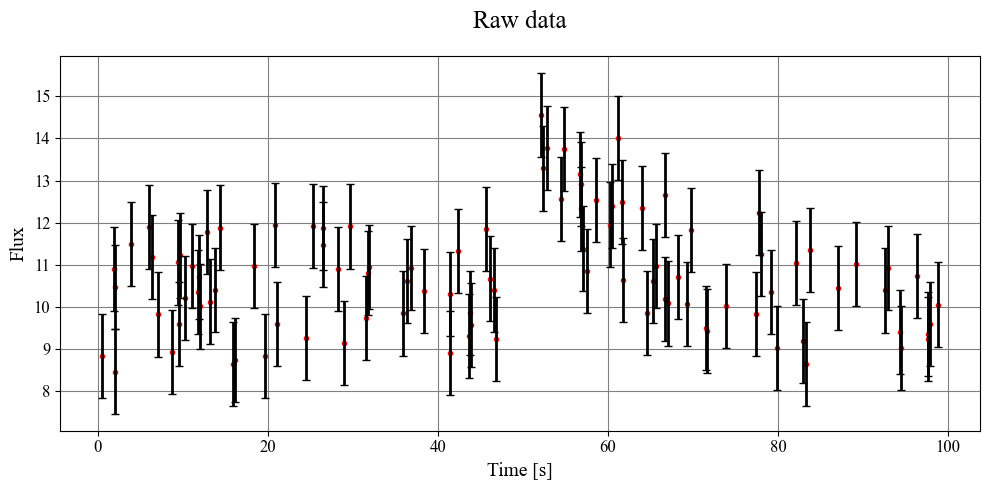

In [7]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True)
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Raw data')

1. **Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{A, t_0,b,\alpha\}$.**

Define the model and initial parameters

In [8]:
def model(x):
    A, t0, alpha, b = x
    return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))

In [9]:
b_estimate = np.mean(flux[time < 40])
A_estimate = np.max(flux)-b_estimate
t0_estimate= time[np.argmax(flux)]
a = np.where(flux-b_estimate < A_estimate/np.e , time, flux)
alpha_estimate = 1/(a[a>t0_estimate][0]-t0_estimate)

In [10]:
x0 = np.array([A_estimate, t0_estimate, alpha_estimate, b_estimate])

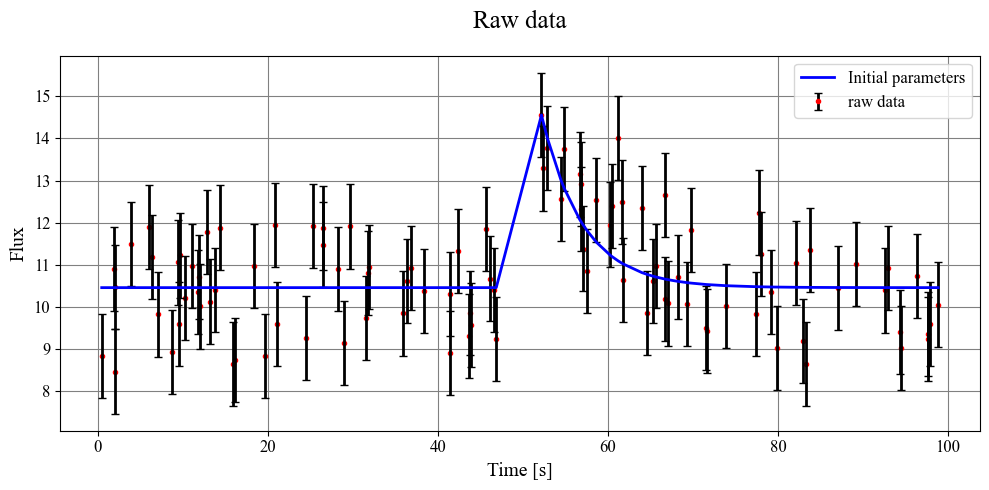

In [11]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True, label='raw data')
plt.plot(time, model(x0), lw=2, color='blue', label='Initial parameters')
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Raw data')
plt.legend()

Define loglikelihood

In [12]:
def pdf(x):
    A, t0, alpha, b = x
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    if np.any(np.isinf(np.exp(-alpha * (time - t0)))):
        return -np.inf
    output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
    return output

def prior(x):
    """
    Log prior for parameters [A, b, alpha, x0].
    Uniform priors:
    - A, b: between 0 and 50
    - alpha: between 0 and 100
    - x0: between exp(-5) and exp(5), uniform in log space
    """
    A, t0, alpha, b = x

    if not (0 <= A <= 50 and 0 <= b <= 50 and 0 <= t0 <= 100 and np.exp(-5) <= alpha <= np.exp(5)):
        return -np.inf  # outside the prior bounds

    log_prior_A     = np.log(1.0 / 50)   # uniform(0, 50)
    log_prior_b     = np.log(1.0 / 50)
    log_prior_alpha = np.log(1.0 / 100)
    log_prior_x0    = np.log(1.0 / (np.exp(5) - np.exp(-5)))

    return log_prior_A + log_prior_b + log_prior_alpha + log_prior_x0

def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, b, alpha, x0].
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * np.sum(((flux - y_model) / ferr)**2)


def posterior(x):
    """
    Log posterior function combining prior and likelihood.
    """
    
    log_prior_value = prior(x)
    if not np.isfinite(log_prior_value):
        return -np.inf

    log_like = log_likelihood(x)
    if not np.isfinite(log_like):
        return -np.inf

    return log_like + log_prior_value



In [13]:
import emcee

In [14]:
n_walkers = 10 # number of walkers I want to crawl the posterior with
n_dim = 4 # dimension of the parameter space
n_steps = int(1e5)

In [15]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, posterior)

In [16]:
x1 = x0 + 1e-2*np.random.randn(n_walkers,n_dim)

In [17]:
sampler.run_mcmc(initial_state=x1, nsteps=n_steps)

State([[ 6.65359182 48.60712604  0.13346383 10.25011025]
 [ 7.12949135 48.16175476  0.13632953 10.29208202]
 [ 7.04378305 49.73161726  0.23145919 10.45261532]
 [ 6.21513839 47.90271368  0.14114549 10.39174375]
 [ 4.13523538 50.84834346  0.10188029 10.38636335]
 [ 5.47587564 50.16002676  0.16098481 10.69885296]
 [ 2.9858293  51.14918359  0.08596752 10.42182695]
 [ 5.0663185  47.60649054  0.08176504 10.19768794]
 [ 6.25932295 48.86260104  0.15180439 10.3604739 ]
 [ 3.8901582  51.30351113  0.12756431 10.36747191]], log_prob=[-66.51487347 -66.46108836 -71.11175848 -67.3688756  -67.30686567
 -72.59393532 -69.21992926 -67.79024365 -67.05035843 -66.67419477], blobs=None, random_state=('MT19937', array([ 121403896, 1486116878, 1180632861, 1741845840, 1926714198,
       3247333824,  835539599, 3903407460, 1352578957, 2324368355,
       3465230027, 2576096124, 4126638428,  860598313, 2810516564,
       3243496651, 3016940899, 1358639759,  510938337, 3228206673,
       1386987841, 4015634818, 178

2. **Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3)**.



In [18]:
samples = sampler.get_chain()

In [19]:
samples.shape

(100000, 10, 4)

In [123]:
labels = [r'$A$', r'$t_0$', r'$\alpha$', r'$b$']

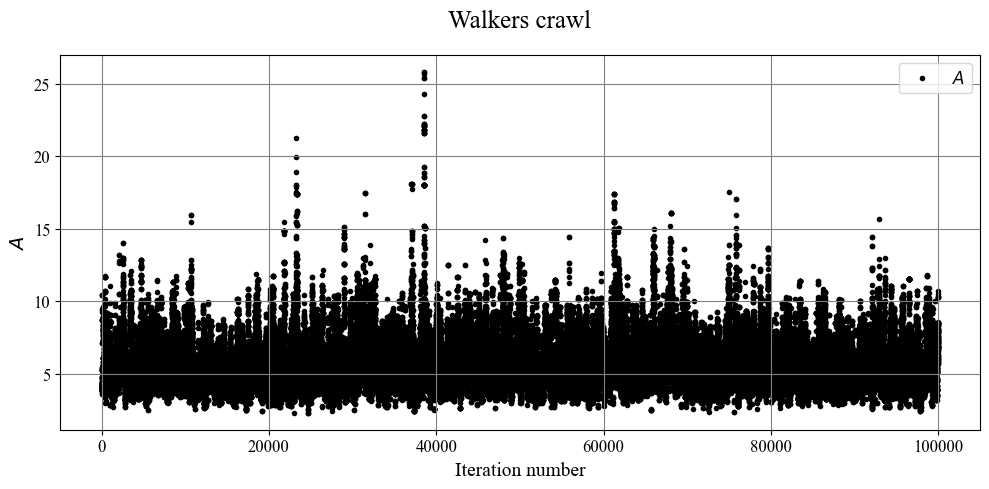

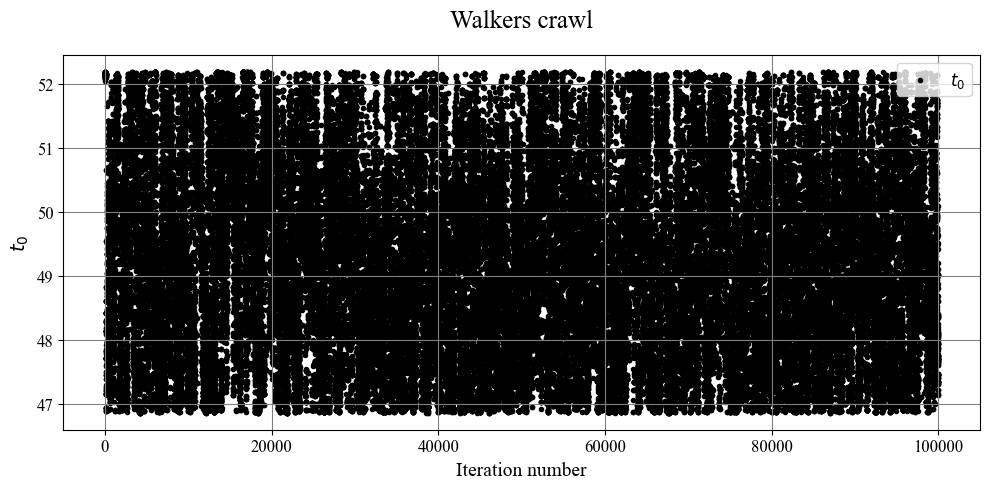

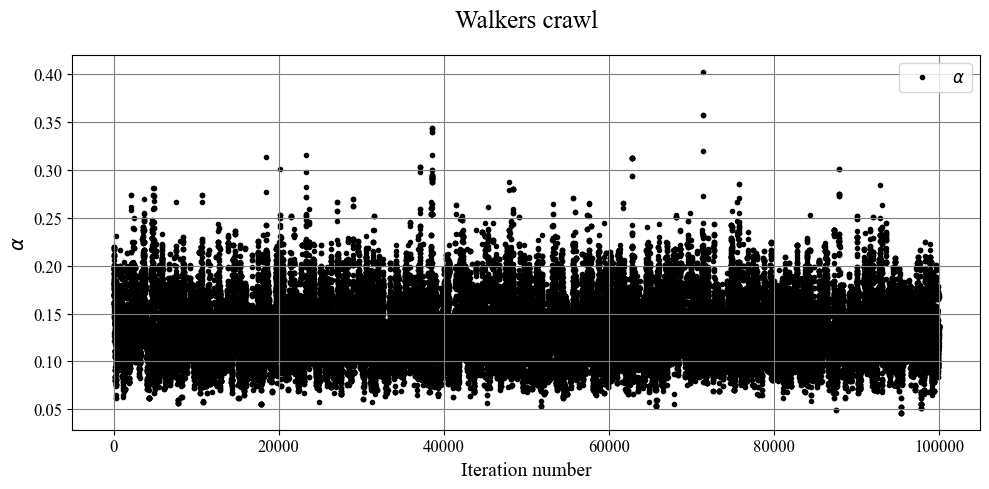

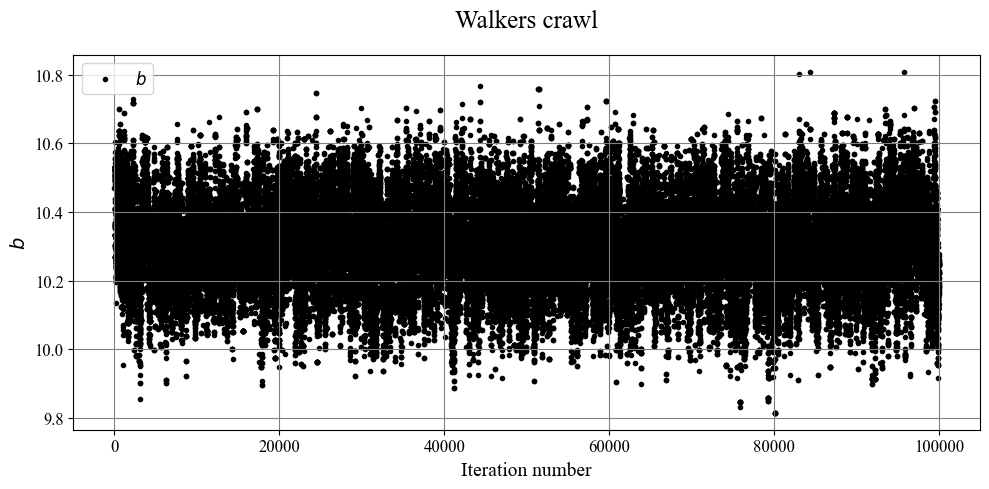

In [21]:
for i in range(n_dim):
    plt.scatter(np.linspace(0,n_steps,n_steps),samples[:, 0,i], marker='.', color='black', label=labels[i])
    plt.ylabel(labels[i])
    plt.legend()
    plt.xlabel('Iteration number')
    plt.title('Walkers crawl')
    plt.show()


In [22]:
tau = sampler.get_autocorr_time()
print(f'Autocorrelation time is {tau}')

Autocorrelation time is [94.3530163  95.12101995 73.27411318 69.37573765]


In [23]:
acceptance_rate = sampler.acceptance_fraction
print(f'Acceptance rates are {acceptance_rate}')

Acceptance rates are [0.53232 0.52564 0.53016 0.5271  0.53073 0.52764 0.52858 0.53297 0.52955
 0.52981]


Discard 10000 points and thin the flattened (only the walker number dimension is flattened now) chains to down_sample...one point every $max(\tau)$ points

In [24]:
samples = sampler.get_chain(discard=10000, thin=int(max(np.array(tau))),flat=True)

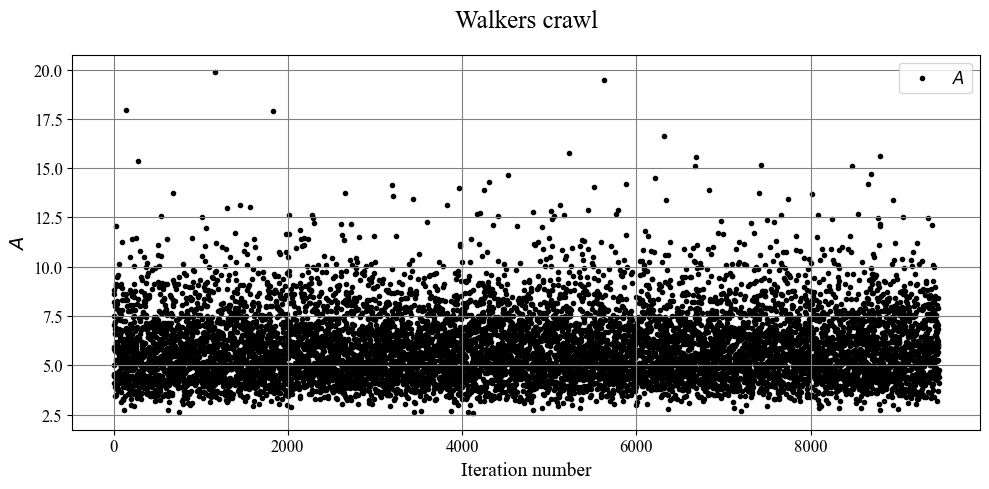

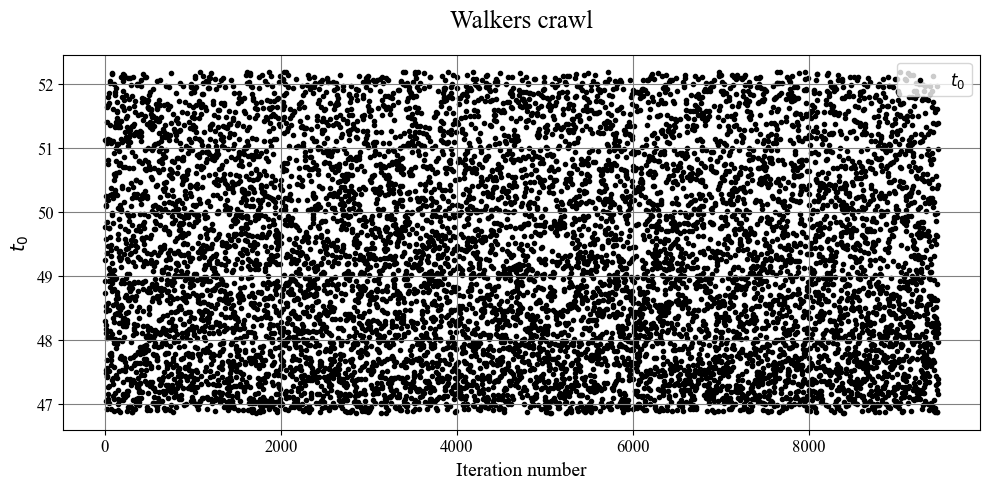

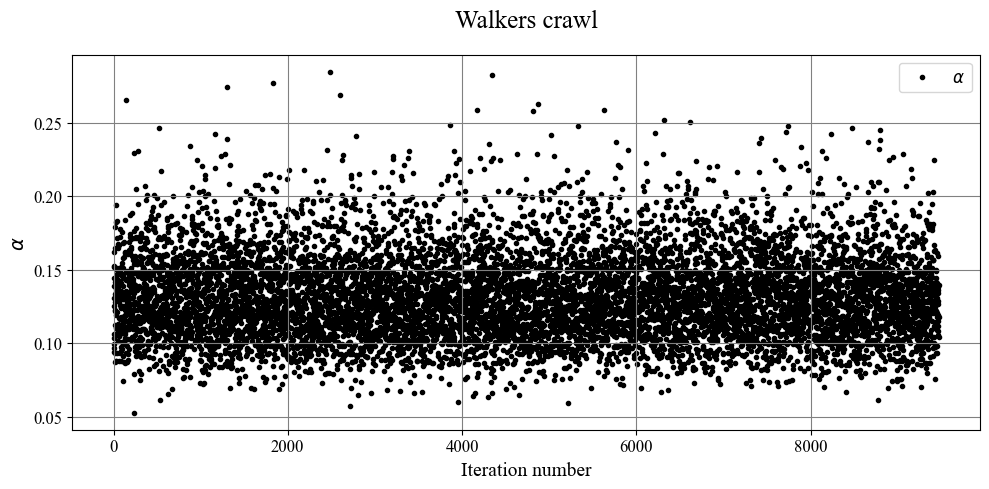

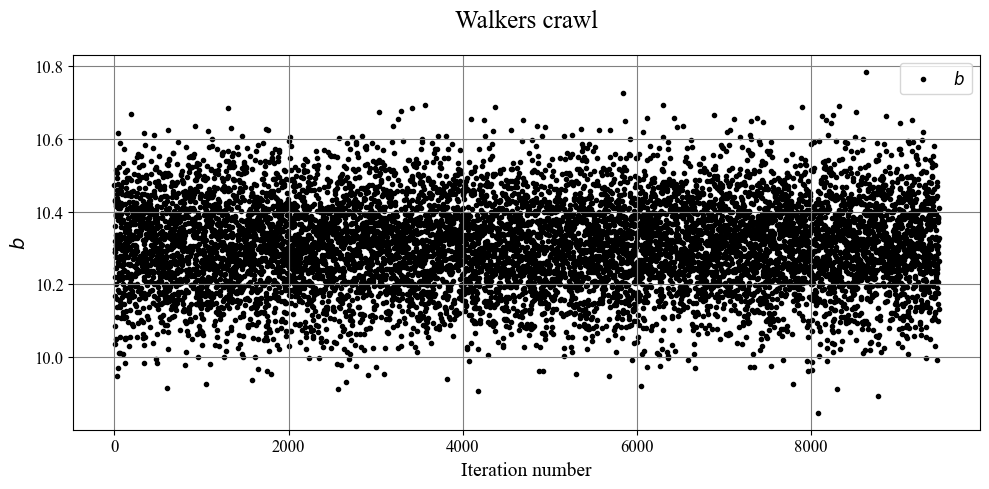

In [25]:
for i in range(n_dim):
    plt.scatter(np.linspace(0,samples[:,i].size,samples[:,i].size),samples[:,i], marker='.', color='black', label=labels[i])
    plt.ylabel(labels[i])
    plt.legend()
    plt.xlabel('Iteration number')
    plt.title('Walkers crawl')
    plt.show()


3. **Make a corner plot of the $4-D$ parameter space, with labels, $[68\%,95\%]$ credible levels and quantiles, and titles**

In [26]:
import corner

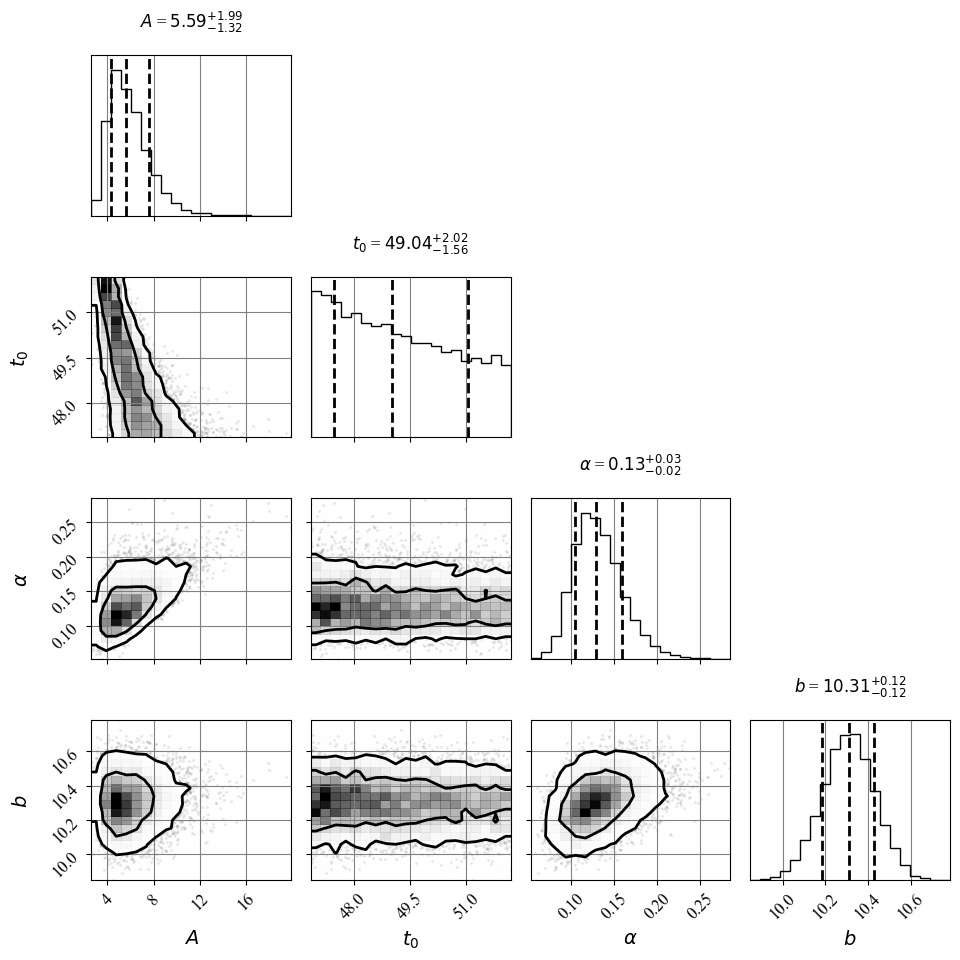

In [27]:
fig = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     # 68% interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)

Comments on corner plot:
1. There is linear correlation between A and t0. 
2. $\alpha$ is independent from $t_0$
3. b is independent from $t_0$

4. **Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.**

In [28]:
randoms = np.vstack([np.random.choice(samples[:,0], size=100) ,np.random.choice(samples[:,1], size=100) ,np.random.choice(samples[:,2], size=100), np.random.choice(samples[:,3], size=100)]).T

Text(0.5, 1.0, 'Randomly chosen parameter estimates')

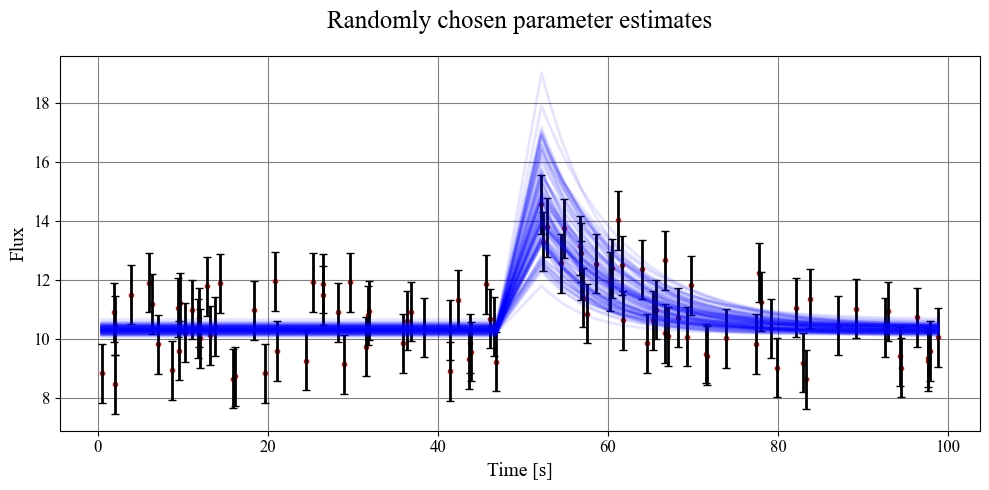

In [29]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True, label='raw data')
for ran in randoms:
    plt.plot(time, model(ran), lw=2, color='blue', alpha=0.1, label='Initial parameters')
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Randomly chosen parameter estimates')

5. **For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0 = \chi^{+Y}_{-Z}$**

In [30]:
from sklearn.neighbors import KernelDensity

In [ ]:
def plot_marginal(i):
    c, b, _ = plt.hist(samples[:, i], bins='scott', density=True,
                       color='blue', alpha=0.4, edgecolor='black', histtype='barstacked')

    median = np.median(samples[:, i])
    mean = np.mean(samples[:, i])
    plt.axvline(median, 0, 1, linestyle='--', color='orange', label=f'median = {median:.2f}')
    plt.axvline(mean, 0, 1, linestyle='-.', color='brown', label=f'mean = {mean:.3f}')

    low, high = np.quantile(samples[:, i], [0.05, 0.95])
    plt.axvline(low, 0, 1, color='brown', linestyle='-.', label='90% credible region')
    plt.axvline(high, 0, 1, color='brown', linestyle='-.')

    plt.xlabel(labels[i])
    plt.ylabel('Density')
    plt.legend()

    x_text = b[0] + 0.7 * (b[-1] - b[0])
    y_text = max(c) * 0.8

    # LaTeX notation with superscript and subscript
    plt.text(
        x_text,
        y_text,
        rf"{labels[i]}$^{{{high:.2f}}}_{{{low:.2f}}}$",
        fontsize=20
    )

    plt.show()
    print()


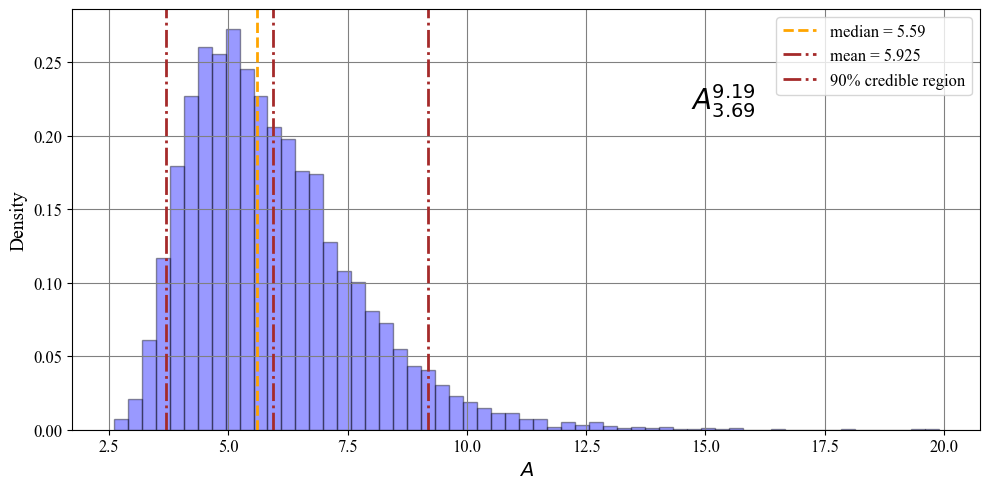

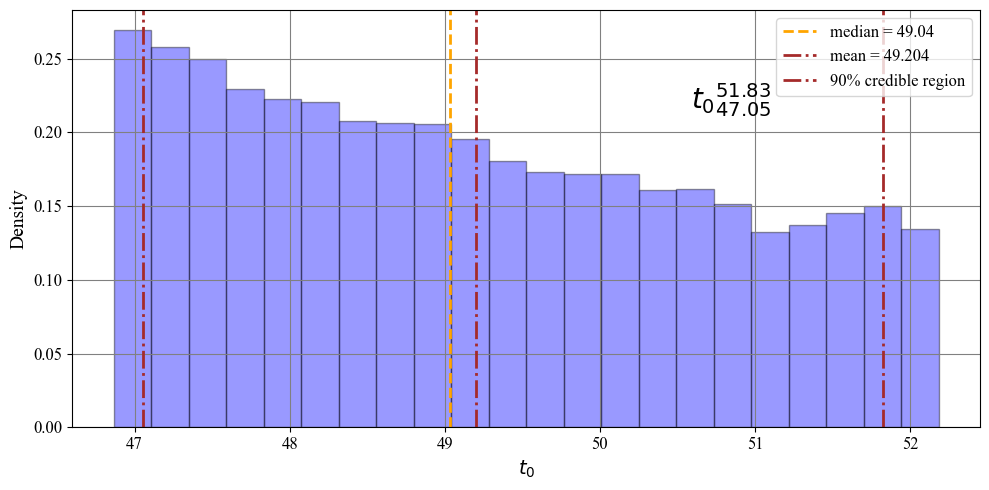

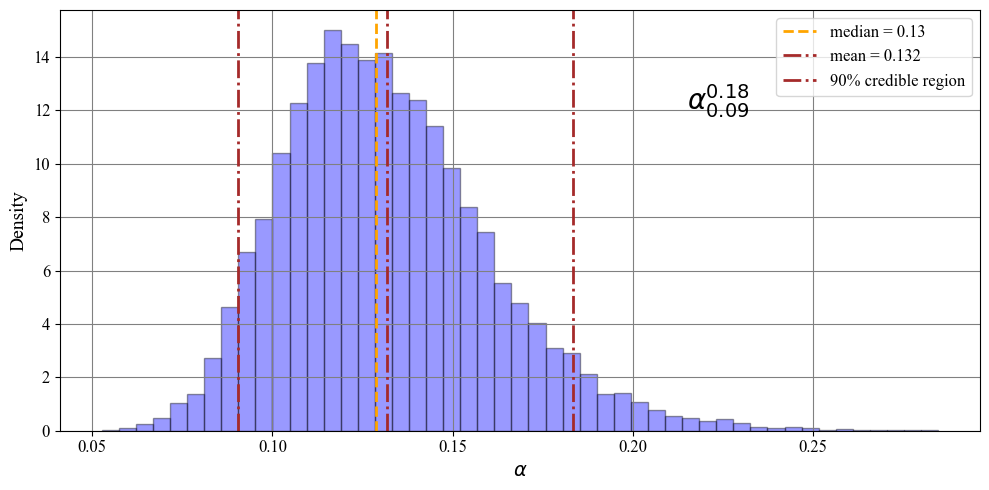

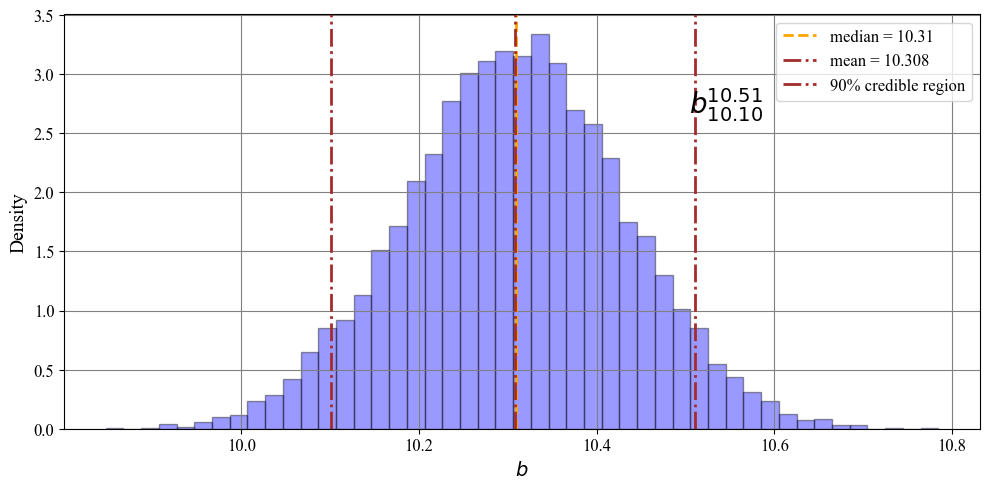

In [34]:
for i in range(n_dim):
    plot_marginal(i)

6. **Fit the same model from before with the same priors, but this time use nested sampling.**

In [ ]:
import dynesty

In [115]:
def pdf(x, model):
    A, t0, alpha, b = x
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    model: string "transient" or "gauss"\
        if "gauss" then REMEMBER that alpha parameter is the inverse of the gaussian variance!!
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    if model=="burst":
        if np.any(np.isinf(np.exp(-alpha * (time - t0)))):
            return -np.inf
        output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
        return output
    elif model=="gauss":
        if np.any(np.isinf(np.exp(-alpha * (time - t0)**2))):
            return -np.inf
        output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
        return output

t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)

def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])

   
    if model =='burst':
        x[2] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[2] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[2] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

def loglike_norm(x,model):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, t0, alpha, b].
    model: string, "burst" or "gauss"
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x,model)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * time.size * np.log(2*np.pi) - np.sum(np.log(ferr)) - 0.5 * np.sum(((flux - y_model) / ferr)**2)

In [116]:
import warnings

In [133]:
with warnings.catch_warnings():
    # Potentially dangerous, but hey I know what I'm doing. 
    # Those warnings come from regions where the likelihood is ~zero
    warnings.simplefilter("ignore", category=RuntimeWarning)
    nested_sampler_burst = dynesty.NestedSampler(loglikelihood=loglike_norm, prior_transform=ptform, ndim=4, sample='rwalk', logl_args=["burst"], ptform_args=["burst"], nlive=500)
    nested_sampler_burst.run_nested()

7845it [10:41, 12.22it/s, +500 | bound: 81 | nc: 1 | ncall: 163621 | eff(%):  5.116 | loglstar:   -inf < -140.676 <    inf | logz: -155.600 +/-    nan | dlogz:  0.001 >  0.509]


In [134]:
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [135]:
sresults_burst = nested_sampler_burst.results

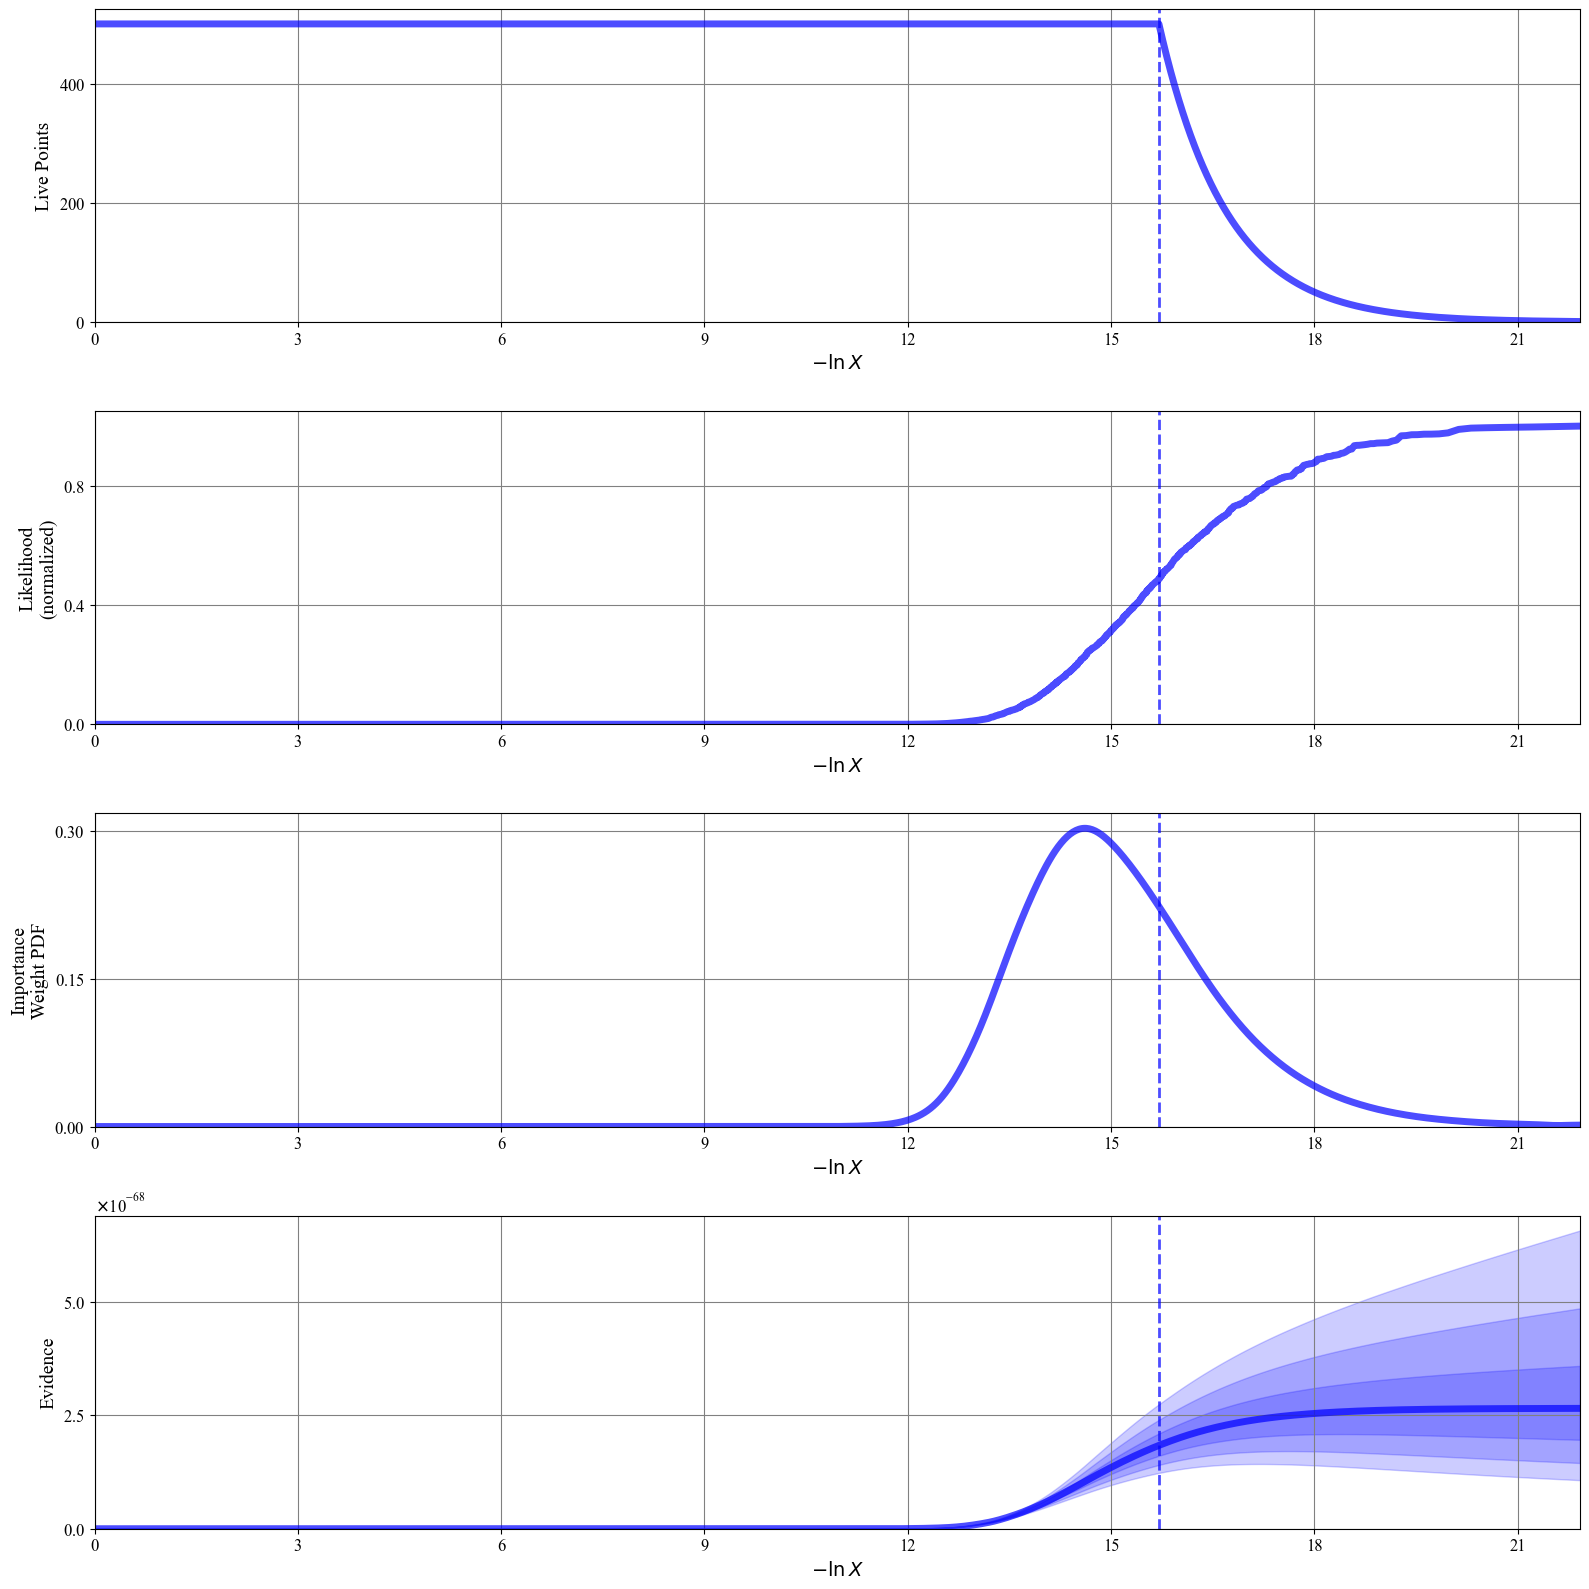

In [136]:
rfig, raxes = dyplot.runplot(sresults_burst)

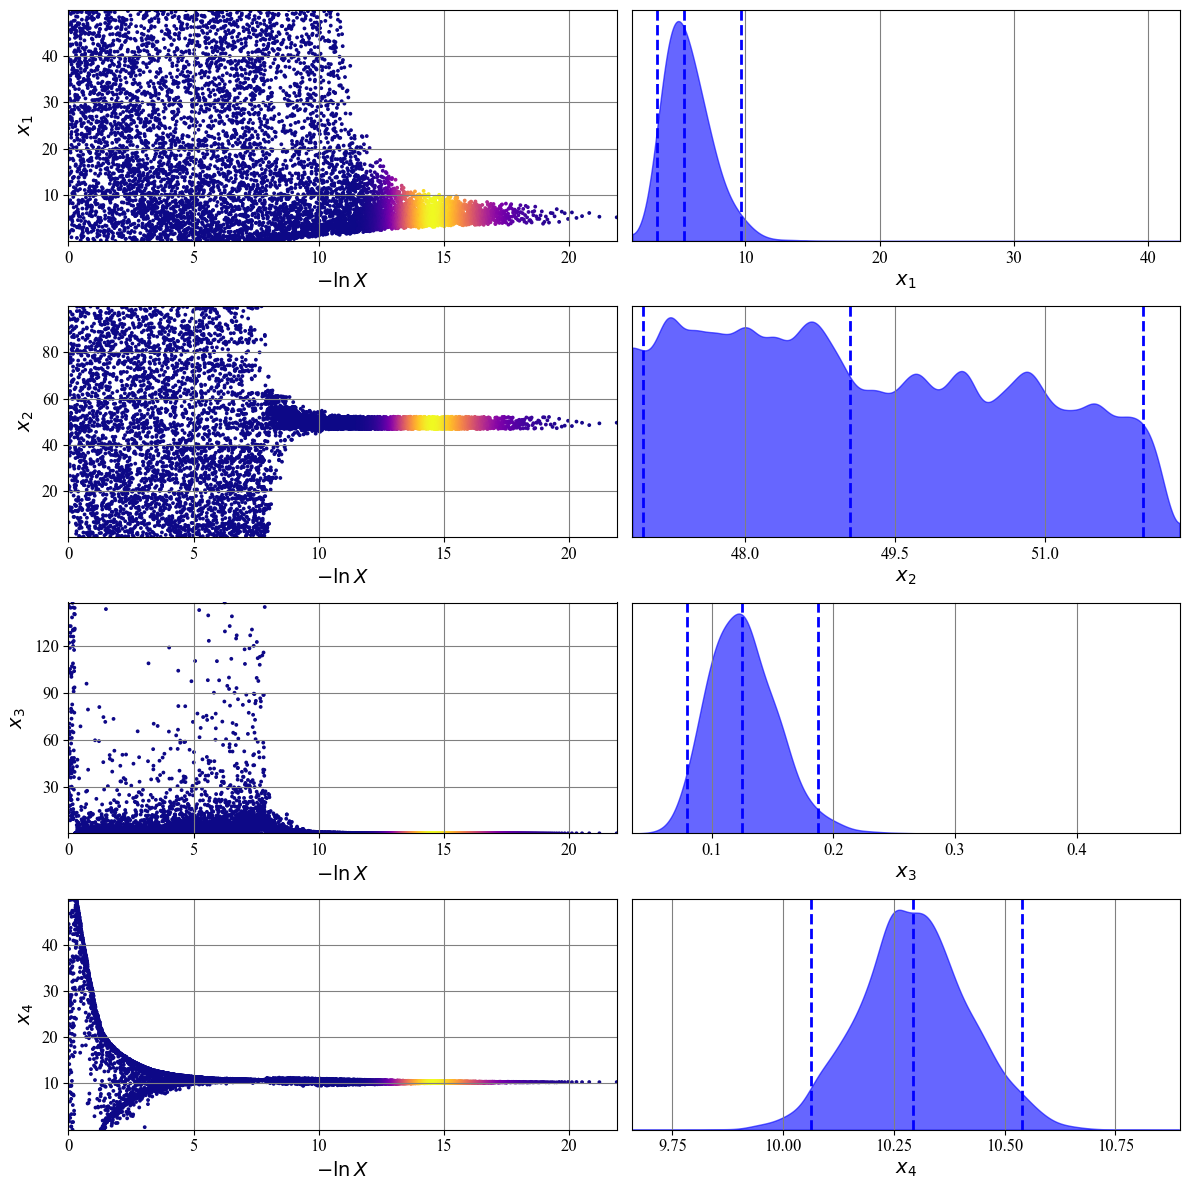

In [137]:
tfig, taxes = dyplot.traceplot(sresults_burst)

In [138]:
samples_burst = sresults_burst.samples  # samples
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])  # normalized weights

samples_equal_burst = dyfunc.resample_equal(samples_burst, weights_burst)

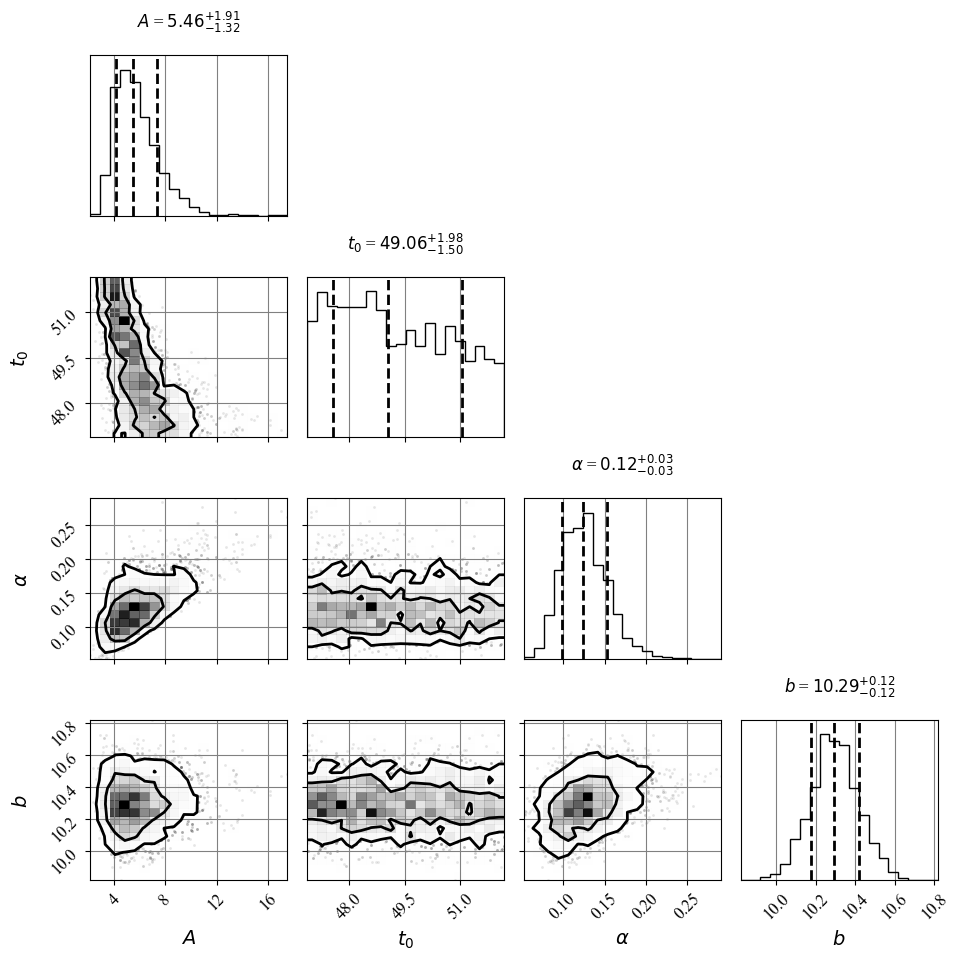

In [139]:
fig = corner.corner(
    samples_equal_burst,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     # 68% interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)

In [140]:
with warnings.catch_warnings():
    # Potentially dangerous, but hey I know what I'm doing. 
    # Those warnings come from regions where the likelihood is ~zero
    warnings.simplefilter("ignore", category=RuntimeWarning)
    nested_sampler = dynesty.NestedSampler(loglikelihood=loglike_norm, prior_transform=ptform, ndim=4, sample='rwalk', logl_args=["gauss"], ptform_args=["gauss"], nlive=500)
    nested_sampler.run_nested()

5901it [06:00, 16.36it/s, +500 | bound: 55 | nc: 1 | ncall: 116957 | eff(%):  5.496 | loglstar:   -inf < -155.352 <    inf | logz: -166.375 +/-  0.143 | dlogz:  0.001 >  0.509]


In [141]:
sresults = nested_sampler.results

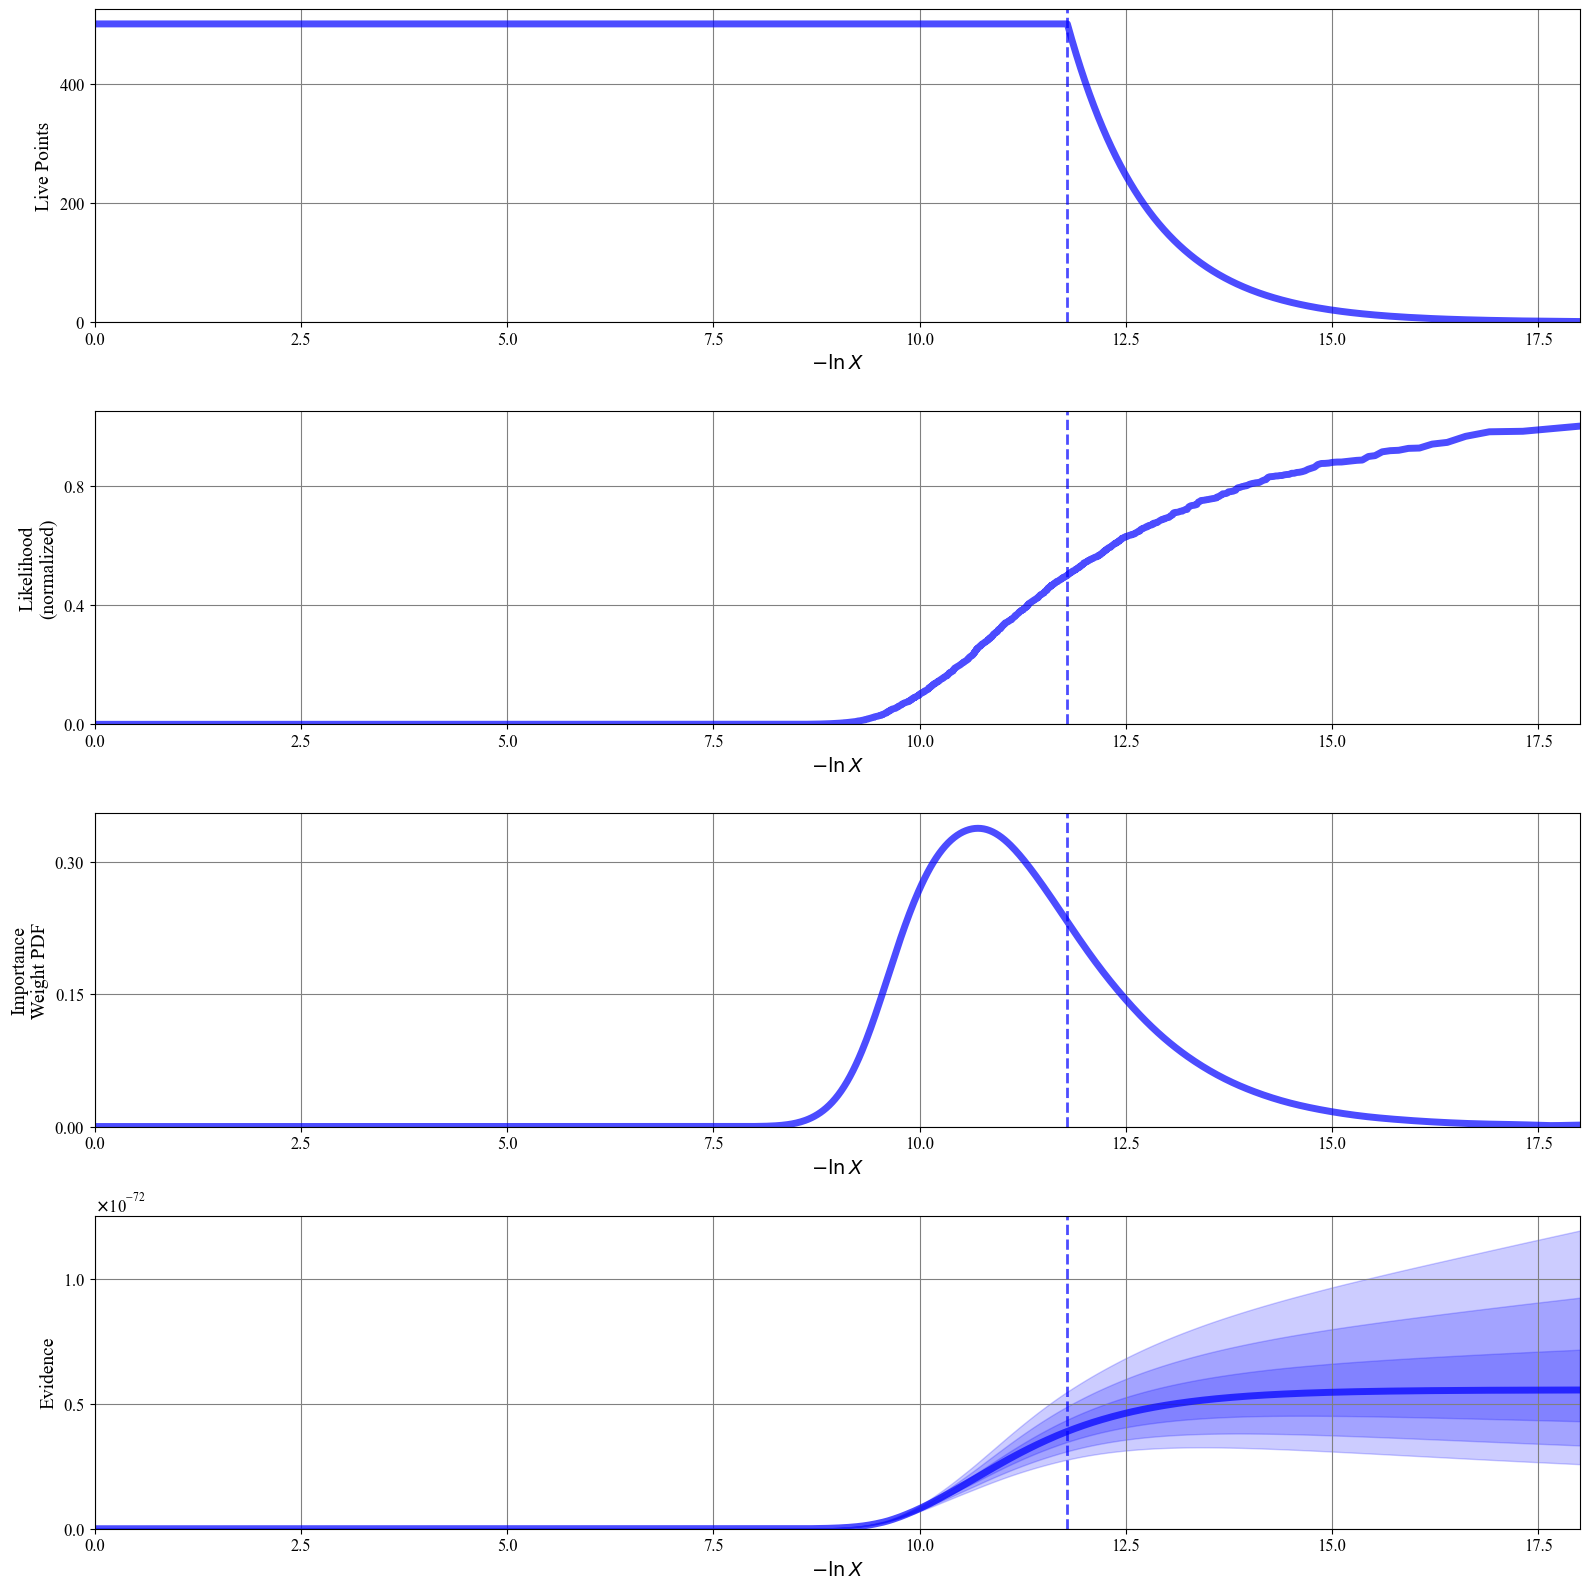

In [142]:
rfig, raxes = dyplot.runplot(sresults)

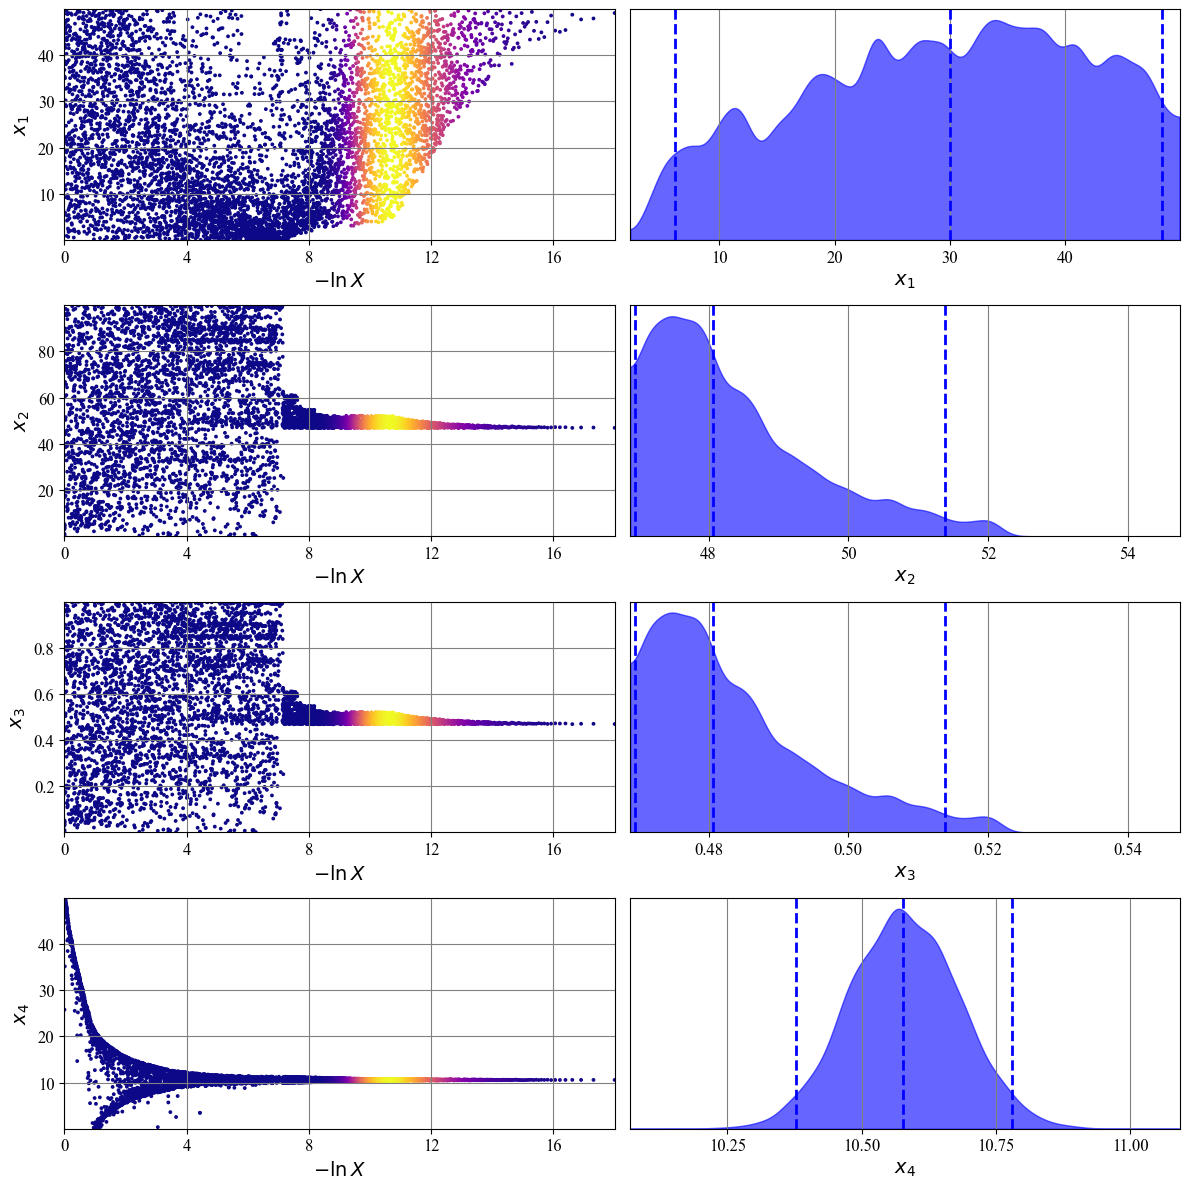

In [143]:
tfig, taxes = dyplot.traceplot(sresults)

In [144]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)

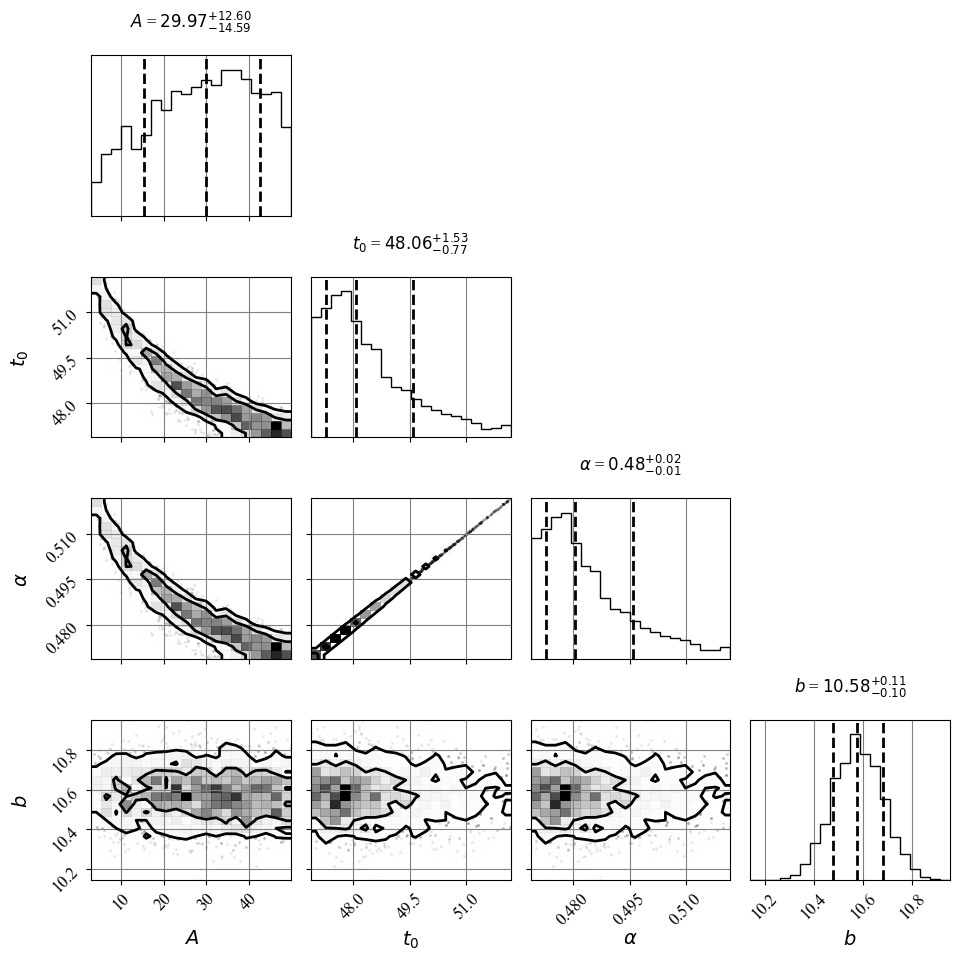

In [145]:
fig = corner.corner(
    samples_equal,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     # 68% interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)